# Self-Attention Analysis

In [1]:
import sys

#@markdown Execute this cell to import third-party software into the Colab environment.

# check whether it runs in Colab
root = "."
if "google.colab" in sys.modules:
    print("Running in Colab.")
    !pip3 install timm==0.5.4
    !pip3 install matplotlib==3.7.1
    !pip3 install scikit-learn==1.2.2
    !pip3 install fastai==2.7.12
    !pip3 install einops==0.6.0
    !pip3 install gdown==4.7.1
    !pip3 install yacs==0.1.8    
    !git clone https://github.com/naver-ai/cl-vs-mim.git
    root = "./cl-vs-mim"
    %cd $root

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'cl-vs-mim' already exists and is not an empty directory.
/content/cl-vs-mim


In [2]:
import torch

#@markdown Execute this cell to check the Colab environment, including GPU availability.

# check gpu env
print(f"Torch: {torch.__version__} \n" + 
      f"Availability: {torch.cuda.is_available()}")
assert torch.cuda.is_available() == True, "The GPU is turned off. To turn it on, navigate to: Runtime > Change Runtime Type."
print(f"Number: {torch.cuda.device_count()} \n" +
      f"Current device: {torch.cuda.current_device()} \n" +
      f"First device: {torch.cuda.device(0)} \n" +
      f"Device name: {torch.cuda.get_device_name(0)}")

Torch: 2.0.1+cu118 
Availability: True
Number: 1 
Current device: 0 
First device: <torch.cuda.device object at 0x7fd749bec7c0> 
Device name: Tesla T4


In [3]:
import os
import math
import numpy as np
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import timm.data.transforms_factory as tff
from fastai.data.external import untar_data, URLs
from utils import subsample

#@markdown Execute this cell to download and import the *Imagenette* dataset, which is a small subset of ImageNet, for simplicity.

# use imagenette (a small subset of imagenet) as an example for simplicity
imagenet_path = untar_data(URLs.IMAGENETTE_160)

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

transform_test = tff.transforms_imagenet_eval(
    img_size=224, mean=imagenet_mean, std=imagenet_std,
)

test_dir = os.path.join(imagenet_path, 'val')
dataset_test = datasets.ImageFolder(test_dir, transform_test)
dataset_test = torch.utils.data.Subset(
    dataset_test, 
    subsample(dataset_test, ratio=math.pow(2,-6))  # use a subsampled batch
)

dataset_test = DataLoader(
    dataset_test, 
    num_workers=1, 
    batch_size=64,
)

## Load the Models

In [4]:
# MoCo
import torch
import models.moco as moco
from models.moco import load_state_dict
from utils import download

#@markdown Execute this cell to download and import MoCo-v3 pre-trained model.

name = "moco_vit_b"  #@param {type:"string"}
path = "checkpoints/moco_vit_b.pt"  #@param {type:"string"}
url = "https://dl.fbaipublicfiles.com/moco-v3/vit-b-300ep/vit-b-300ep.pth.tar"  #@param {type:"string"}

download(url, path, force=False)  # download checkpoints

model = moco.vit_base()
model = model.cuda()
model = model.eval()

state_dict = load_state_dict(path)
_ = model.load_state_dict(state_dict, strict=False)
model_moco = model

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# SimMIM 
import gdown
import torch
import models.simmim as simmim
from models.simmim import load_state_dict

#@markdown Execute this cell to download and import SimMIM pre-trained model.

name = "simmim_vit_b"  #@param {type:"string"}
path = "checkpoints/simmim_vit_b.pt"  #@param {type:"string"}
url = "https://drive.google.com/u/1/uc?id=1dJn6GYkwMIcoP3zqOEyW1_iQfpBi8UOw"  #@param {type:"string"}

gdown.cached_download(url, path, quiet=False)  # download checkpoints

model = simmim.vit_base()
model = model.cuda()
model = model.eval()

state_dict = load_state_dict(path)
_ = model.load_state_dict(state_dict, strict=False)
model_simmim = model

File exists: checkpoints/simmim_vit_b.pt
=> merge config from configs/simmim_pretrain__vit_base__img224__800ep.yaml


## Attention Map Visualization

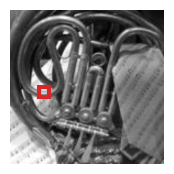

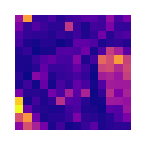

In [6]:
# visualize attns with samples
import matplotlib.pyplot as plt

def mark_token(ax, xs, batch, i, j, color='tab:red'):
    import matplotlib.patches as patches
    from einops import rearrange, reduce, repeat
    from utils import restore
    
    ax.imshow(rearrange(restore(xs.cpu())[batch], 'c h w -> h w c'))
    ax.set_axis_off()

    # create a rectangle patch to visualize the query token
    rect = patches.Rectangle((14 * i, 14 * j), 14, 14, linewidth=3, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

def visualize_attn(ax, attns, batch, i, j, depth, head):
    """
    ax: matplotlib axes
    xs: batch
    batch, i, j: batch coords 
    attns, depth, head: 
    """
    
    attn_list = [list(attn[batch].cpu()) if attn is not None else None for attn in attns]
    attn = torch.stack(attn_list[depth])
    attn = attn[head]  # take head-th head
    attn = attn[1:,1:]  # drop cls token
    attn = attn / attn.sum(dim=-1, keepdim=True)  # normalize

    attn = attn[j * 14 + i]
    attn = attn.reshape([14, 14])

    ax.imshow(attn, cmap="plasma", )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()
    
    
#@markdown Execute this cell to visualize the attention maps. The red square in the visualization indicates the location of the query.
#@markdown 
#@markdown This visualization demonstrates that the self-attentions of CL (MoCo) generally captures global relationships and objects. However, they tend to produce homogeneous attention maps for all query tokens and heads, particularly when compared to MIM. In contrast, the self-attentions of MIM (SimMIM) primarily focus on localized areas.

model_option = "moco"  #@param ["moco", "simmim"]
depth = 10  #@param {type:"slider", min:0, max:11, step:1}
batch = 30  #@param {type:"integer"}
coord_x = 3  #@param {type:"integer"}
coord_y = 8  #@param {type:"integer"}
head = 0  #@param {type:"integer"}

if model_option == "moco":
    model = model_moco
elif model_option == "simmim":
    model = model_simmim
else:
    raise Exception("Invalid option: ", model_option)

xs, ys = next(iter(dataset_test))
with torch.no_grad():
    xs = xs.cuda()
    _, _, attns, _ = model(xs)


fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=100)
mark_token(ax, xs, batch=batch, i=coord_x, j=coord_y, color='tab:red')

fig, ax = plt.subplots(1, 1, figsize=(1, 1), dpi=150)
visualize_attn(ax, attns, batch=batch, i=coord_x, j=coord_y, depth=depth, head=head)

## Attention Distance

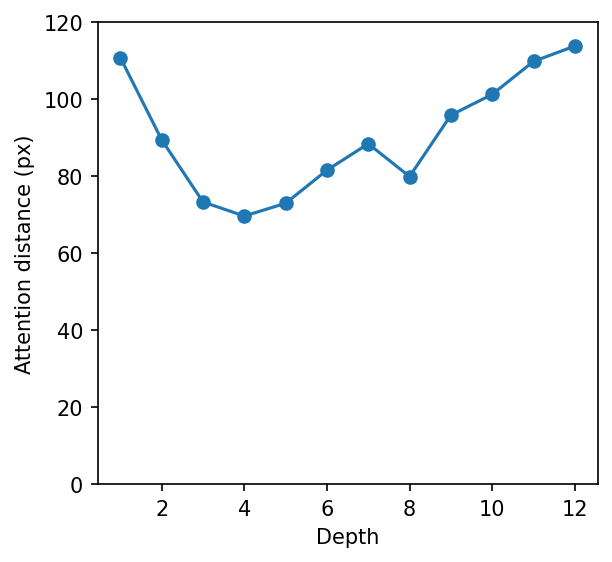

In [7]:
# build off the implementation of https://github.com/sayakpaul/probing-vits
import numpy as np

def compute_distance_matrix(patch_size, num_patches, length):
    """Helper function to compute distance matrix."""
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j: # zero distance
                continue

            xi, yi = (int(i/length)), (i % length)
            xj, yj = (int(j/length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix

def calculate_mean_attention_dist(patch_size, attention_weights):
    """ The attention_weights shape = (batch, num_heads, num_patches, num_patches)"""
    
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert (length**2 == num_patches), ("Num patches is not perfect square")

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape

    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    # The attention_weights along the last axis adds to 1
    # this is due to the fact that they are softmax of the raw logits
    # summation of the (attention_weights * distance_matrix)
    # should result in an average distance per token
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(mean_distances, axis=-1) # sum along last axis to get average distance per token
    mean_distances = np.mean(mean_distances, axis=-1) # now average across all the tokens

    return torch.tensor(mean_distances)


#@markdown Execute this cell to calculate attention distance. Attention distance is defined as the average distance between the query tokens and key tokens considering their self-attention weights. Therefore, it conceptually corresponds to the size of the receptive fields in CNNs.
#@markdown 
#@markdown These results shows that the attention distance of CL (MoCo) is significantly higher than that of MIM (SimMIM), especially in the later layers. As seen above, the qualitative visualization, this implies that the representations of CL contain global patterns and shape information, so CL can help ViTs distinguish between objects of images. Conversely, the self-attentions of MIM mainly capture local relationships; i.e., MIM may have difficulty recognizing whole objects and their shapes.

from timm.utils import AverageMeter

model_option = "moco"  #@param ["moco", "simmim"]
if model_option == "moco":
    model = model_moco
elif model_option == "simmim":
    model = model_simmim
else:
    raise Exception("Invalid option: ", model_option)
    
encoder_length = len(model.blocks)  # for example 12 for ViT-B
distances = [AverageMeter() for _ in range(encoder_length)]

for idx, (xs, _) in enumerate(dataset_test):
    xs = xs.cuda()
    
    with torch.no_grad():
        _, _, attns, _ = model(xs)
        
    for i, attn in enumerate([attn for attn in attns if attn is not None]):    
        attn = attn[:,:,1:,1:]
        attn = attn + 1e-32
        attn = attn / attn.sum(dim=-1, keepdim=True)  # normalize
        attn = attn.cpu().float().detach().numpy()

        distance = calculate_mean_attention_dist(patch_size=16, attention_weights=attn)
        distances[i].update(torch.mean(distance, dim=0))  # average w.r.t. batch
        
    if idx > -1:
        break
    

fig, ax = plt.subplots(1, 1, figsize=(4.3, 4), dpi=150)
distances = [torch.mean(distance.avg) for distance in distances]
ax.plot(range(1, 13), distances, marker="o")
ax.set_xlabel("Depth")
ax.set_ylabel("Attention distance (px)")
ax.set_ylim(top=120, bottom=0)
plt.show()

## Normalized Mutual Information

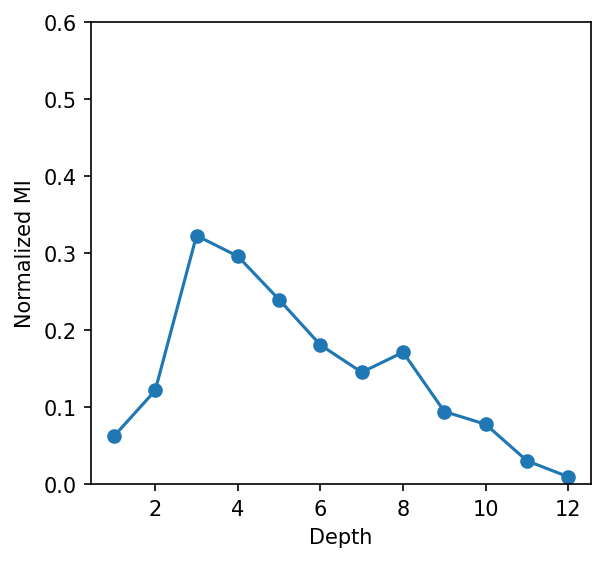

In [8]:
import torch.nn.functional as F 
from einops import rearrange, reduce, repeat

def calculate_nmi(attn): 
    """ Normalized mutual information with a return type of (batch, head) """
    b, h, q, k = attn.shape
    pq = torch.ones([b, h, q]).to(attn.device)
    pq = F.softmax(pq, dim=-1)
    pq_ext = repeat(pq, "b h q -> b h q k", k=k)
    pk = reduce(attn * pq_ext, "b h q k -> b h k", "sum")
    pk_ext = repeat(pk, "b h k -> b h q k", q=q)
    
    mi = reduce(attn * pq_ext * torch.log(attn / pk_ext), "b h q k -> b h", "sum")
    eq = - reduce(pq * torch.log(pq), "b h q -> b h", "sum")
    ek = - reduce(pk * torch.log(pk), "b h k -> b h", "sum")
    
    nmiv = mi / torch.sqrt(eq * ek)
    
    return nmiv

#@markdown Execute this cell to calculate the Normalized Mutual Information (NMI). NMI measures the inhomogeneity of self-attentions with respect to queries. In other words, *attention collapse* occurs when the NMI approaches zero.
#@markdown 
#@markdown The results indicate that the mutual information of CL is significantly lower than that of MIM, especially in the later layers. This suggests that the self-attentions of CL tend to collapse into homogeneous distributions.


from timm.utils import AverageMeter

model_option = "moco"  #@param ["moco", "simmim"]
if model_option == "moco":
    model = model_moco
elif model_option == "simmim":
    model = model_simmim
else:
    raise Exception("Invalid option: ", model_option)

encoder_length = len(model.blocks)  # 12 for ViT-B
nmis = [AverageMeter() for _ in range(encoder_length)]

for idx, (xs, _) in enumerate(dataset_test):
    xs = xs.cuda()
    
    with torch.no_grad():
        _, _, attns, _ = model(xs)
        
    for i, attn in enumerate([attn for attn in attns if attn is not None]):
        attn = attn[:,:,1:,1:]  # drop cls token
        attn = attn + 1e-8
        attn = attn / attn.sum(dim=-1, keepdim=True)  # normalize
        attn = attn.cpu().float()
        
        nmi = calculate_nmi(attn)
        nmis[i].update(torch.mean(nmi, dim=0))  # average w.r.t. batch
        
    if idx > -1:
        break
    
    
fig, ax = plt.subplots(1, 1, figsize=(4.3, 4), dpi=150)
nmis = [torch.mean(nmi.avg) for nmi in nmis]
ax.plot(range(1, 13), nmis, marker="o")
ax.set_xlabel("Depth")
ax.set_ylabel("Normalized MI")
ax.set_ylim(top=0.6, bottom=0.0)
plt.show()